<a href="https://colab.research.google.com/github/qusrud0113/Audio-Sentiment-Classification/blob/main/2023_05_16_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%9D%8C%EC%84%B1_%EA%B0%90%EC%A0%95_%EC%9D%B8%EC%8B%9D_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023.05.16
Dataset Info.

train [폴더]

    학습을 위한 소리 샘플
    TRAIN_0000.wav ~ TRAIN_5000.wav


test [폴더]

    추론을 위한 소리 샘플
    TEST_0000.wav ~ TEST_1880.wav


train.csv [파일]

    id : 샘플 별 고유 ID
    path : 음향 샘플 파일 경로
    label : 감정의 종류
    0: angry
    1: fear
    2: sad
    3: disgust
    4: neutral
    5: happy


test.csv [파일]

    id : 샘플 별 고유 ID
    path : 음향 샘플 파일 경로


sample_submission.csv [파일] - 제출 양식

    id : 샘플 별 고유 ID
    label : 예측한 감정의 종류


This Crowd-sourced Emotional Mutimodal Actors Dataset (CREMA-D) is made available under the Open Database License: 

http://opendatacommons.org/licenses/odbl/1.0/. 

Any rights in individual contents of the database are licensed under the Database Contents License: 

http://opendatacommons.org/licenses/dbcl/1.0/



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_dir = '/content/drive/MyDrive/데이콘/데이콘 음성 감정 인식/open'

In [4]:
import pandas as pd

train_df = pd.read_csv(file_dir + '/train.csv')
test_df = pd.read_csv(file_dir + '/test.csv')

In [5]:
train_df['path'] = [i.replace('./train', file_dir+'/train') for i in train_df['path']]

In [6]:
test_df['path'] = [i.replace('./test', file_dir+'/test') for i in test_df['path']]

In [7]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = { 0: 'angry'
			,1: 'fear'
			,2: 'sad'
			,3: 'disgust'
			,4: 'neutral'
			,5: 'happy'}
SAMPLE_RATE = 48000

In [8]:
print("number of files is {}".format(len(train_df)))

number of files is 5001


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [10]:
EMOTIONS[0]

'angry'

In [11]:
def relabel(x):
    return EMOTIONS[x]

Text(0, 0.5, 'Number of examples')

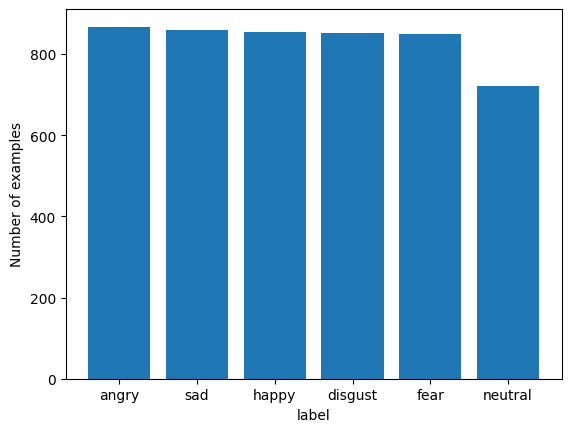

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = train_df['label'].value_counts()
ax.bar(x=[relabel(i) for i in list(counts.index)], height=counts.values)
ax.set_xlabel('label')
ax.set_ylabel('Number of examples')

In [25]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=fac430ff9b2d4e23f9aa5e7b84a0076e7e3ba5c02dc679d19a2d2d8dbddb4efe
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [98]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Time Series', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].plot(list(signals.values())[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Fourier Transform', size = 16, position = (0.5, 1.2))
    i = 0
    i = 0
    for y in range(6):
        data = list(fft.values())[i]
        Y,freq = data[0], data[1]        
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].plot(freq, Y)
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Filter Bank Coefficients', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].imshow(list(fbank.values())[i],
                     cmap = 'hot', interpolation = 'nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1
            
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].imshow(list(mfccs.values())[i],
                        cmap = 'hot', interpolation = 'nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1


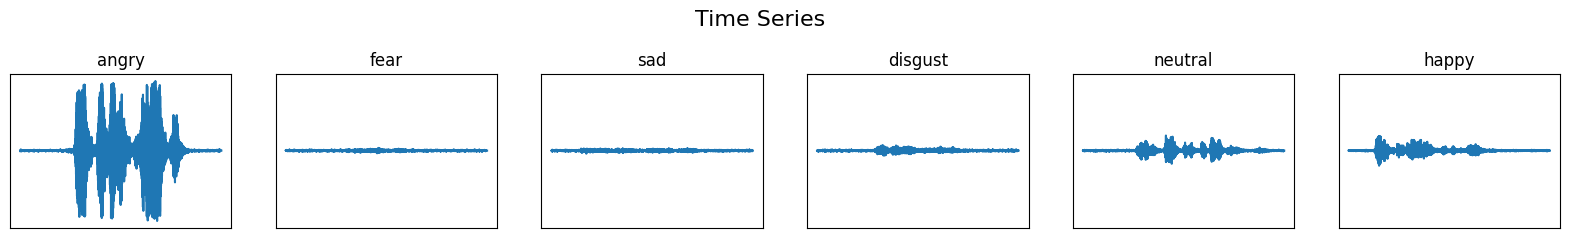

In [93]:
from python_speech_features import mfcc, logfbank

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

classes = list(np.unique(train_df.label))


signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = train_df[train_df.label == c].iloc[0,0]
    signal, rate = librosa.load(file_dir+'/train/'+wav_file+'.wav', sr=44100)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()


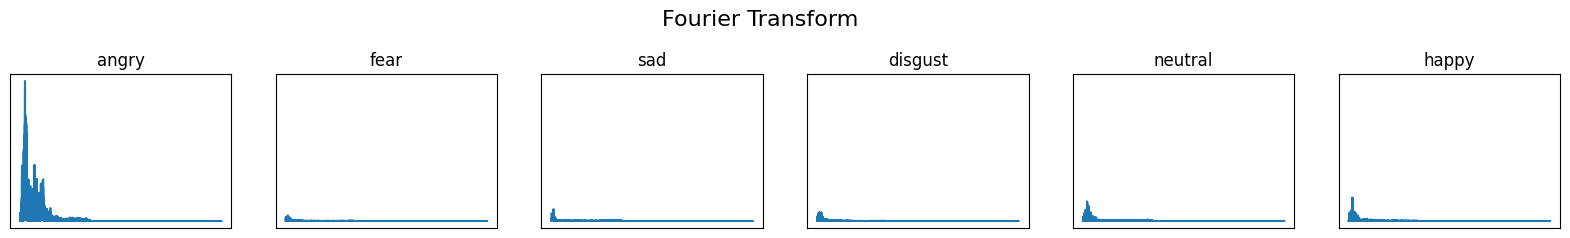

In [94]:
plot_fft(fft)
plt.show()

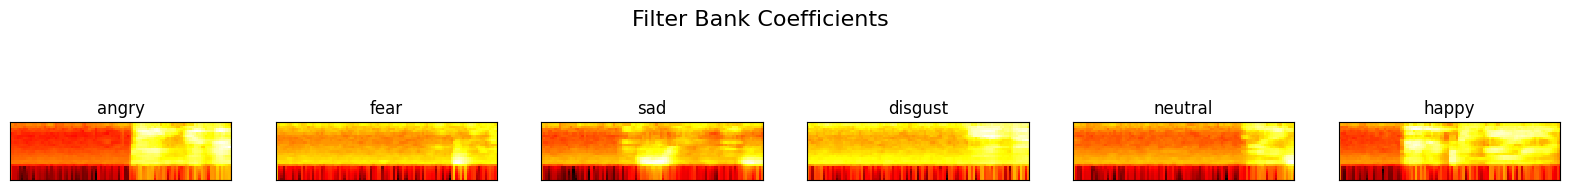

In [99]:
plot_fbank(fbank)
plt.show()

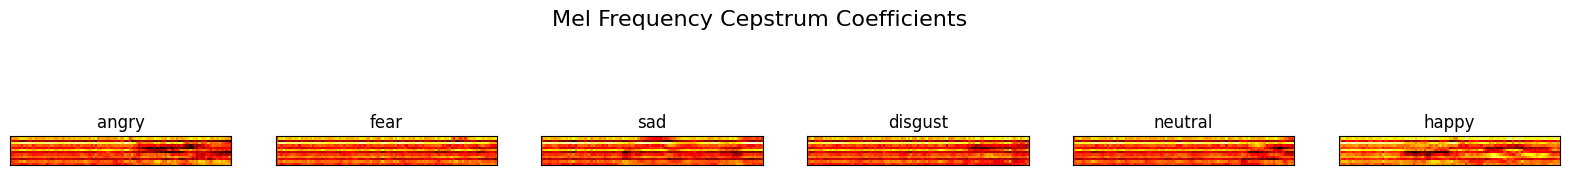

In [100]:
plot_mfccs(mfccs)
plt.show()

In [101]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


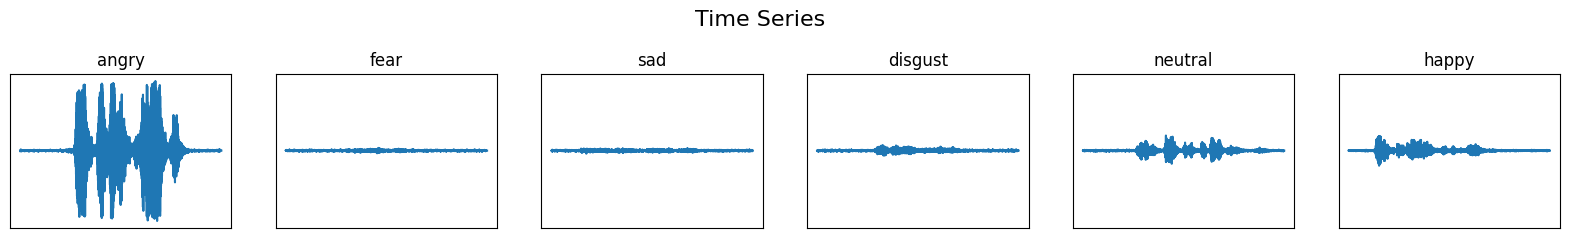

In [103]:
for c in classes:
    wav_file = train_df[train_df.label == c].iloc[0,0]
    signal, rate = librosa.load(file_dir+'/train/'+wav_file+'.wav', sr = 44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()


In [ ]:
import seaborn as sns
import wave

# 오디오 프레임 수를 반환
train_df['nframes'] = train_df['path'].apply(lambda f: wave.open(f).getnframes())
test_df['nframes'] = test_df['path'].apply(lambda f: wave.open(f).getnframes())


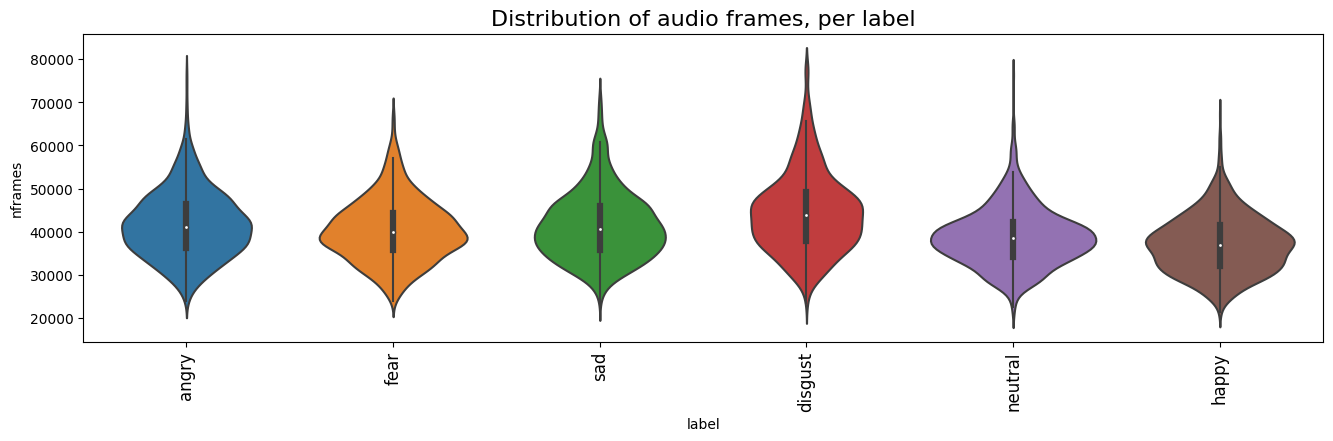

In [121]:
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train_df)
plt.xticks(rotation=90)
ax.set_xticklabels([relabel(i) for i in train_df.label.drop_duplicates().sort_values()], fontsize=12)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()


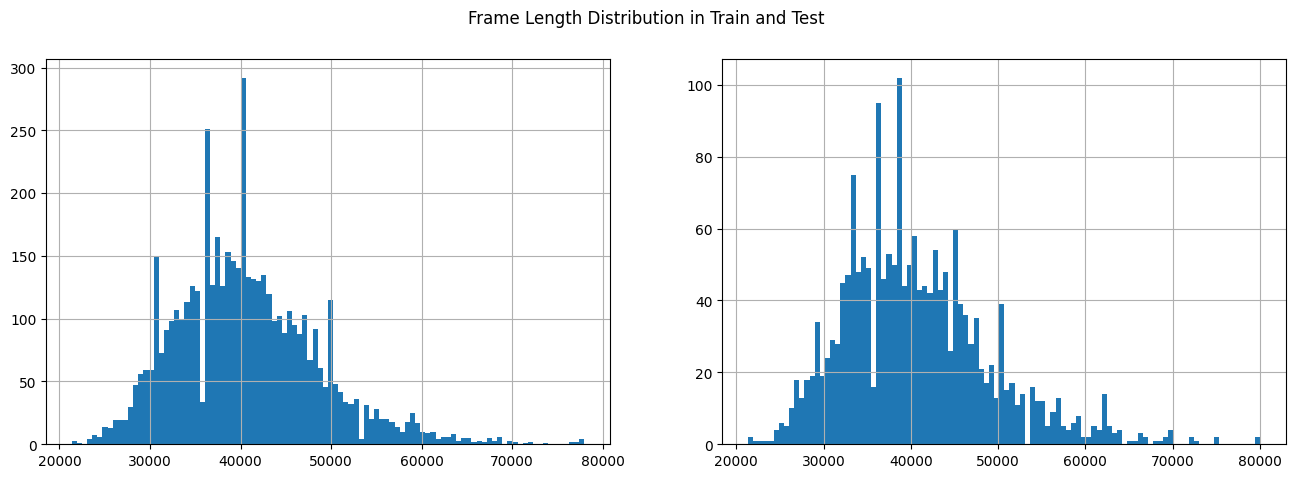

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train_df.nframes.hist(bins=100, ax=axes[0])
test_df.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');